# Initial EDA

Objectives:
- Have a first look at the dataset
- Calculate some basic descriptive statistics
- Inspect feature distributions and determine whether any transformation may be required
- Inspect target class imbalance

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from pathlib import Path

# May require pip installation
from tqdm.auto import tqdm

In [2]:
!ls

Adaboost.ipynb       InitialEDA.ipynb     XGBoost.ipynb
Boosted Models.ipynb Preprocessing.ipynb  student.ipynb


In [3]:
!ls ../data

bank-full.csv  bank-names.txt


In [4]:
!cat ../data/bank-names.txt

In [5]:
f_path = Path("../data/bank-full.csv")

df = pd.read_csv(f_path, delimiter=";")

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [8]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [9]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## Normality Investigation

In [10]:
cont_cols = ["age", "balance", "duration"]

In [12]:
plots_dir = Path("../plots/eda")

assert plots_dir.is_dir()

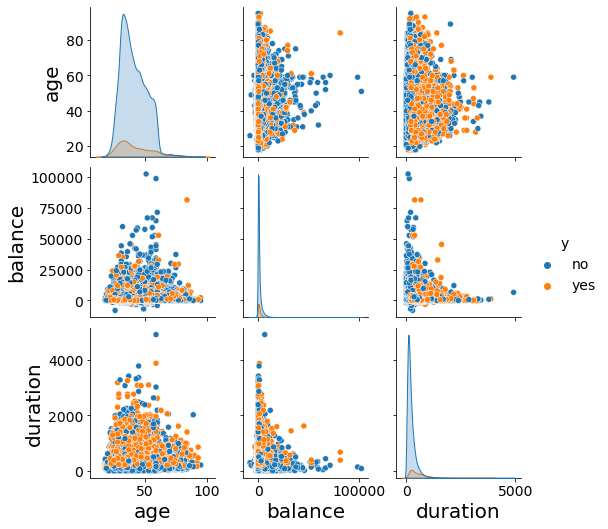

In [18]:
plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 20})

sns.pairplot(df[cont_cols+["y"]], hue="y")

plt.savefig(plots_dir/"pairplot_og.png", bbox_inches="tight")
plt.show()

The distribution of some continuous features are highly skewed, thus it may be worth normalising the data through various transforms.

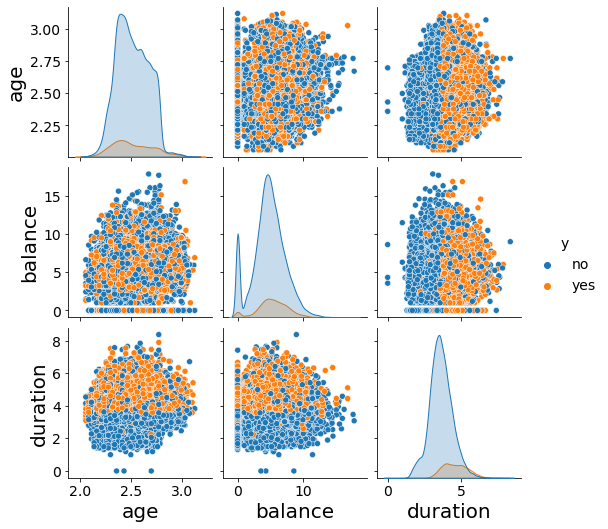

In [20]:
# Power transform

sns.pairplot((df[cont_cols]**0.25).join(df.y), hue="y")
plt.savefig(plots_dir/"pairplot_power_transform.png", bbox_inches="tight")

plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


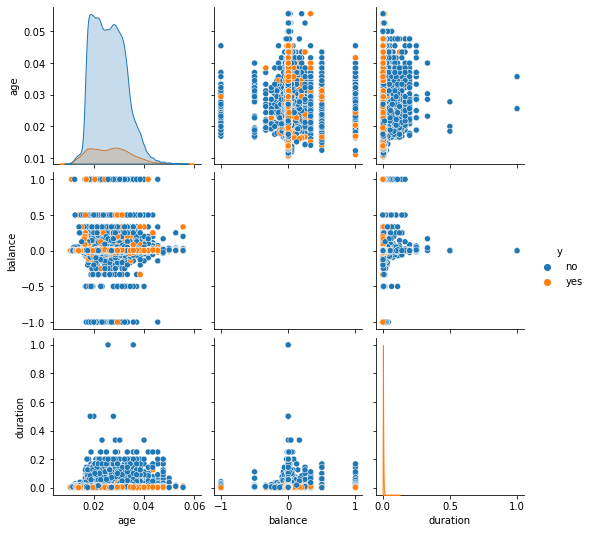

In [22]:
# Power transform - inverse transf

sns.pairplot((df[cont_cols].astype(float)**-1).join(df.y), hue="y")

plt.show()

The power transform seems to have successfully made the distributions 'more normal'.

## Class Imbalance

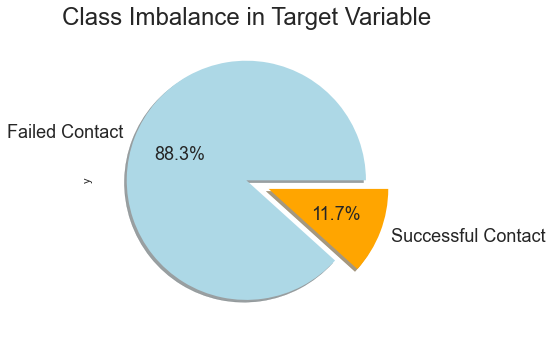

In [73]:
plt.style.use("seaborn")
fig, ax = plt.subplots()
df.y.value_counts().plot(kind="pie", fontsize=18, ax=ax, explode=[0, 0.2], shadow=True,
                             labels=["Failed Contact", "Successful Contact"],
                        autopct=lambda x: f"{np.round(x, 2)}%", colors=["lightblue", "orange"])
ax.set_title("Class Imbalance in Target Variable", fontsize=24)
plt.savefig(plots_dir/"class_imbalance.png", bbox_inches="tight")
plt.show()

In [74]:
df.y.value_counts(normalize=True)

no     0.883015
yes    0.116985
Name: y, dtype: float64

There appears to be a huge class imbalance, with positive examples representing only 10% of the dataset. As such, a skill-less baseline classifier would be 88% accurate and we should report metrics such as F1-score and precision when delivering our final classifier.

We should also consider applying sampling techniques to even this class imbalance. SMOTE may be a good choice, however, we must be wary of imputing too much of our training data. It may be worth downsampling the negative examples and upsampling the positive with SMOTE. We could also just specify class weights (if supported by the model).

## Investigating Categorical Columns

In [75]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [76]:
cat_cols = [col for col in df.columns[:-1] if df[col].dtype == "object"]
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [77]:
len(cat_cols)

9

  0%|          | 0/9 [00:00<?, ?it/s]

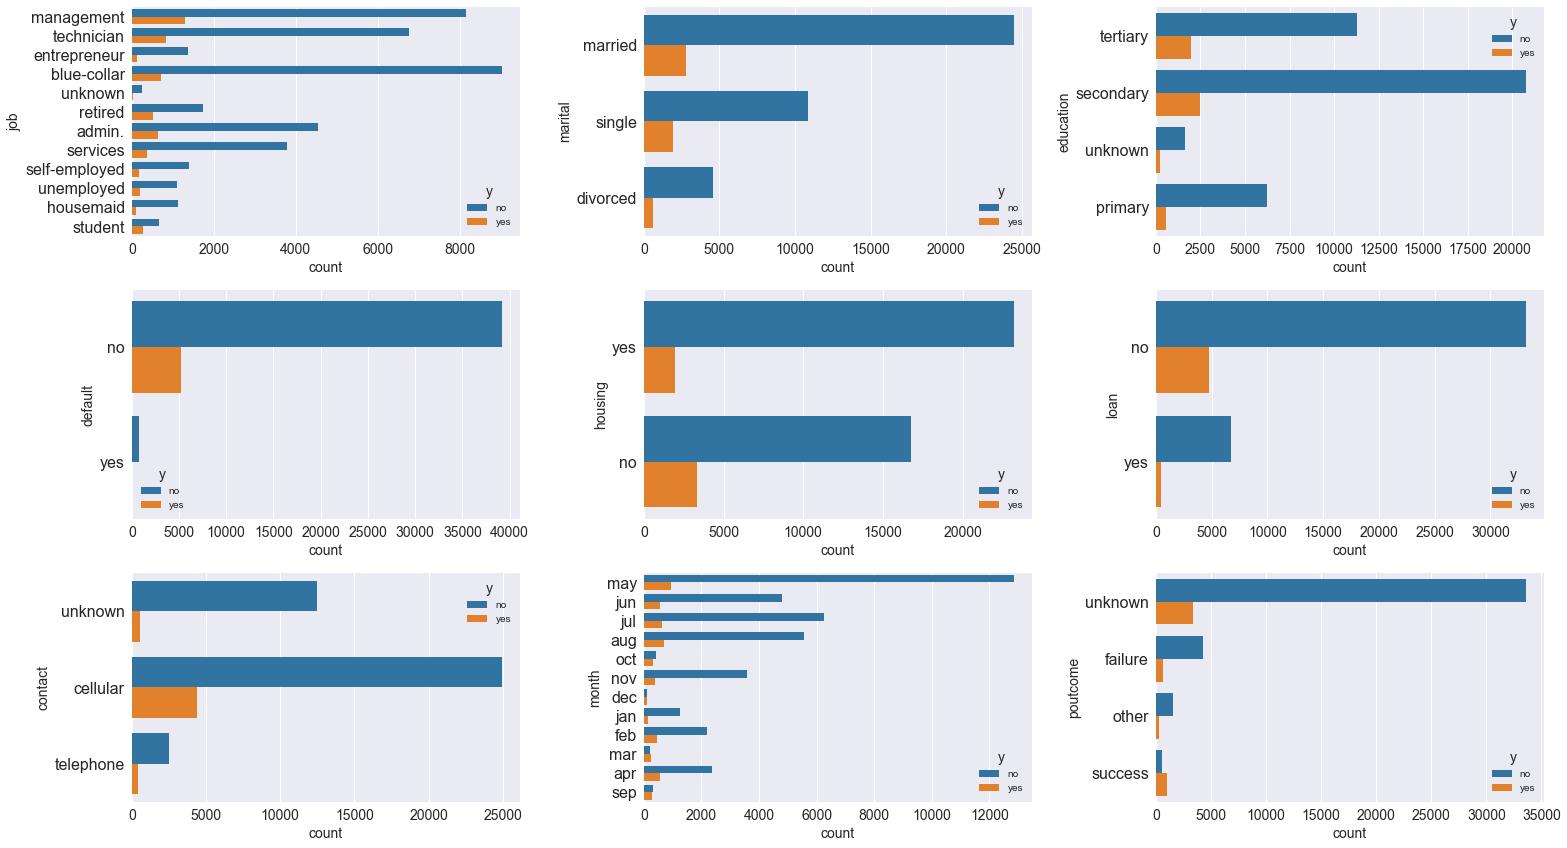

In [143]:
fig, axs = plt.subplots(3, 3, figsize=(22, 12))

plt.rcParams.update({'axes.labelsize': 14,
                    'xtick.labelsize': 14,
                    'ytick.labelsize': 16})

df_cat_y = df[cat_cols+["y"]]
for col, ax in tqdm(zip(cat_cols, np.ravel(axs)), total=len(cat_cols)):
#     df[col].value_counts().plot(kind='barh', ax=ax, fontsize=14)
    sns.countplot(y=col, hue="y", data=df_cat_y, ax=ax, palette=sns.color_palette("tab10"))
    
fig.tight_layout()

plt.savefig(plots_dir/"class_imbalance_barplots.png", bbox_inches="tight")
plt.show()

In [21]:
!cat ../data/bank-names.txt | grep previous

Columns such as `previous` and `poutcome` have a high cardinality but very low variance. As such, it may be worth binning or altogether dropping these features.